### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle

### Загрузка данных

In [2]:
df_purchase = pd.read_csv('purchase data.csv')

### Исследование данных

In [3]:
df_purchase.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0


In [5]:
df_purchase.isnull().sum()

ID                   0
Day                  0
Incidence            0
Brand                0
Quantity             0
Last_Inc_Brand       0
Last_Inc_Quantity    0
Price_1              0
Price_2              0
Price_3              0
Price_4              0
Price_5              0
Promotion_1          0
Promotion_2          0
Promotion_3          0
Promotion_4          0
Promotion_5          0
Sex                  0
Marital status       0
Age                  0
Education            0
Income               0
Occupation           0
Settlement size      0
dtype: int64

Данные были обработы, поэтому пропусков нет. использовать метод describe не имеет смысла, так переменные преимущественно категориальные

## Сегментирование данных

### Импорт модели для сегментирования

In [6]:
scaler = pickle.load(open('scaler.pickle', 'rb'))

In [7]:
pca = pickle.load(open('pca.pickle', 'rb'))

In [8]:
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

### Стандартизация данных

In [9]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

### PCA

In [10]:
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

### K-means PCA

In [11]:
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

In [12]:
df_purchase_predictors = df_purchase.copy()

In [13]:
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca

## Описательный анализ по сегментам

## Анализ данных по клиентам

In [30]:
df_purchase_predictors.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,47,1,110866,1,0,2
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,2
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,2
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,47,1,110866,1,0,2
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,2


In [31]:
#во временную переменную помещаем данные о числе визитов, сгруппированные по ID
temp1 = df_purchase_predictors[['ID', 'Incidence']].groupby(['ID'], as_index=False).count()
temp1 = temp1.set_index('ID')
temp1 = temp1.rename(columns = {'Incidence': 'N_Visits'})
temp1.head()

,N_Visits
ID,
200000001,101
200000002,87
200000003,97
200000004,85
200000005,111


во втором наборе данные о числе покупок, совместим их с ранее созданным temp1

In [32]:
temp2 = df_purchase_predictors[['ID', 'Incidence']].groupby(['ID'], as_index=False).sum()
temp2 = temp2.set_index('ID')
temp2 = temp2.rename(columns = {'Incidence': 'N_Purchases'})
temp3 = temp1.join(temp2)

In [33]:
temp3.head()

,N_Visits,N_Purchases
ID,,
200000001,101,9
200000002,87,11
200000003,97,10
200000004,85,11
200000005,111,13


Рассчитаем среднее число покупок для каждого клиента

In [34]:

temp3['Average_N_Purchases'] = temp3['N_Purchases']/temp3['N_Visits']
temp3.head()

,N_Visits,N_Purchases,Average_N_Purchases
ID,,,
200000001,101,9,0.089109
200000002,87,11,0.126437
200000003,97,10,0.103093
200000004,85,11,0.129412
200000005,111,13,0.117117


Добавим информацию о том, к какому сегменту принадлежит каждый клиент

In [35]:

temp4 = df_purchase_predictors[['ID', 'Segment']].groupby(['ID'], as_index=False).mean()
temp4 = temp4.set_index('ID')
df_purchase_descr = temp3.join(temp4)
df_purchase_descr.head()

,N_Visits,N_Purchases,Average_N_Purchases,Segment
ID,,,,
200000001,101,9,0.089109,2
200000002,87,11,0.126437,0
200000003,97,10,0.103093,2
200000004,85,11,0.129412,2
200000005,111,13,0.117117,1


### Пропорции сегментов по покупкам

In [29]:
segm_prop = df_purchase_descr[['N_Purchases', 'Segment']].groupby(['Segment']).count() / df_purchase_descr.shape[0]
segm_prop = segm_prop.rename(columns = {'N_Purchases': 'Segment proportions'})
segm_prop.head()

,Segment proportions
Segment,
0,0.196
1,0.210
2,0.406
3,0.188


Отобразим данные на графике, для этого хорошо подойдёт Pie-chart

Text(0.5, 1.0, 'Segment Proportions')

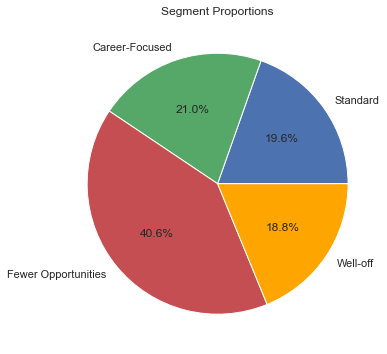

In [23]:

plt.figure(figsize=(9,6))
plt.pie(segm_prop['Segment proportions'],
       labels = ['Standard', 'Career-Focused', 'Fewer Opportunities', 'Well-off'],
       autopct='%1.1f%%',
       colors = ('b', 'g', 'r', 'orange'))
plt.title('Segment Proportions')

Несмотря на то, что сегмент Standart наиболее многочисленен, на него приходится довольно мало покупок (применительно к брендам из набора данных)


### Частота покупок

Выведем средние значения по числу визитов, покупок и покупок за визит для сегментов


In [40]:
segments_mean = df_purchase_descr.groupby(['Segment']).mean()
segments_mean

,N_Visits,N_Purchases,Average_N_Purchases
Segment,,,
0,117.295918,34.602041,0.284478
1,124.428571,41.847619,0.294155
2,113.719212,22.768473,0.201751
3,117.531915,23.734043,0.205481


Выведем также стандартное отклонение

In [41]:

segments_std = df_purchase_descr.groupby(['Segment']).std()
segments_std

,N_Visits,N_Purchases,Average_N_Purchases
Segment,,,
0,20.716152,25.900579,0.171787
1,46.085176,55.433741,0.207227
2,16.236037,13.584739,0.118552
3,18.410903,13.414946,0.116267


Построим столбчатые диаграммы на основе полученной информации

Text(0, 0.5, 'Число визитов')

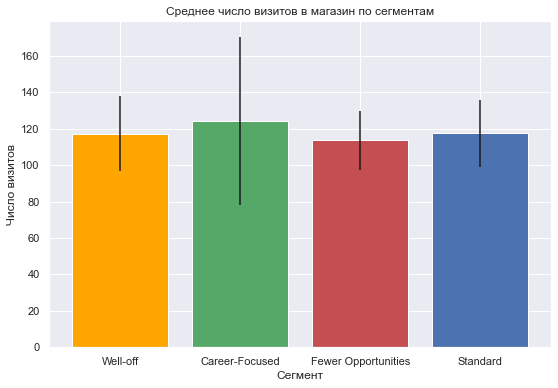

In [45]:
plt.figure(figsize=(9,6))
plt.bar(x = (0,1,2,3),
       tick_label = ('Well-off', 'Career-Focused', 'Fewer Opportunities', 'Standard'),
       height = segments_mean['N_Visits'],
       yerr = segments_std['N_Visits'],
       color = ('orange', 'g', 'r', 'b'))
plt.title('Среднее число визитов в магазин по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Число визитов')

В среднем, чаще всех посещают магазины "Карьеристы", но в этом же сегменте наиболее сильны различия по данному признаку.

Text(0, 0.5, 'Число покупок')

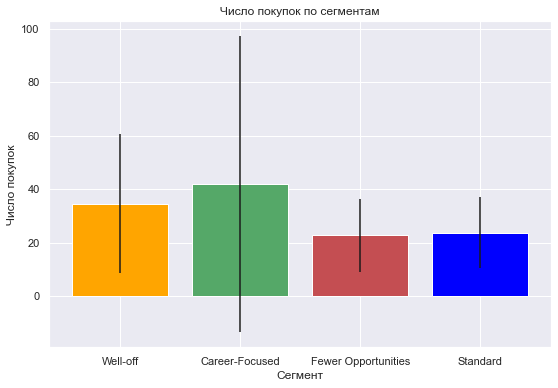

In [46]:
plt.figure(figsize=(9,6))
plt.bar(x = (0,1,2,3),
       tick_label = ('Well-off', 'Career-Focused', 'Fewer Opportunities', 'Standard'),
       height = segments_mean['N_Purchases'],
       yerr = segments_std['N_Purchases'],
       color = ('orange', 'g', 'r', 'blue'))
plt.title('Число покупок по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Число покупок')

Здесь снова выделяется сегмент карьеристов с наибольшим числом покупок и наибольшими внутри-групповыми различиями.

Text(0, 0.5, 'Среднее число покупок')

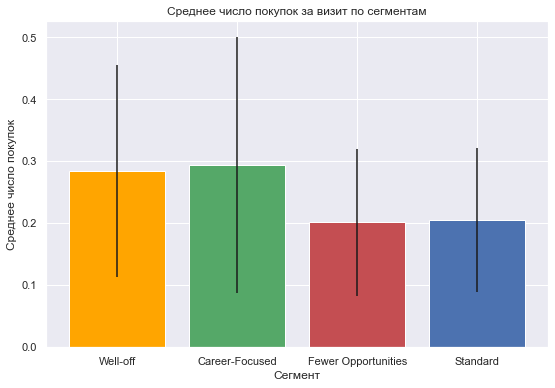

In [49]:
plt.figure(figsize=(9,6))
plt.bar(x = (0,1,2,3),
       tick_label = ('Well-off', 'Career-Focused', 'Fewer Opportunities', 'Standard'),
       height = segments_mean['Average_N_Purchases'],
       yerr = segments_std['Average_N_Purchases'],
       color = ('orange', 'g', 'r', 'b'))
plt.title('Среднее число покупок за визит по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Среднее число покупок')

### Выбор бренда


Выберем из набора данных только те визиты, при которых была совершена покупка

In [60]:
df_purchase_incidence = df_purchase_predictors[df_purchase_predictors['Incidence']==1]

In [61]:
brand_dummies = pd.get_dummies(df_purchase_incidence['Brand'], prefix = 'Brand', prefix_sep='_')
brand_dummies['Segment'], brand_dummies['ID'] = df_purchase_incidence['Segment'], df_purchase_incidence['ID']

In [62]:
brand_dummies

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Segment,ID
6,0,1,0,0,0,2,200000001
11,0,0,0,0,1,2,200000001
19,1,0,0,0,0,2,200000001
24,0,0,0,1,0,2,200000001
29,0,1,0,0,0,2,200000001
...,...,...,...,...,...,...,...
58621,0,1,0,0,0,2,200000500
58648,1,0,0,0,0,2,200000500
58674,0,1,0,0,0,2,200000500
58687,0,1,0,0,0,2,200000500


In [63]:
temp = brand_dummies.groupby(['ID'], as_index=True).mean()

Посмотрим, как в каждом сегменте распределены доли брендов

In [64]:
mean_brand_choice = temp.groupby(['Segment'], as_index=True).mean()

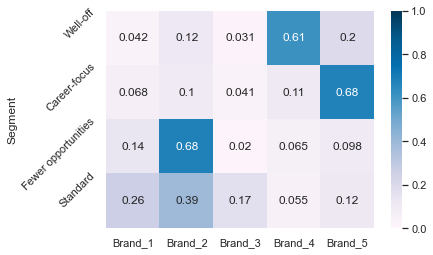

In [65]:
sns.heatmap(mean_brand_choice, vmin = 0, vmax=1, cmap='PuBu', annot = True)
plt.yticks([0,1,2,3], ['Well-off', 'Career-focus', 'Fewer opportunities', 'Standard'], rotation = 45)
plt.show()

- Наиболее обеспеченный сегмент предпочитает Бренд 4, на втором и третьем местах с большим отрывом Бренды 5 и 2
- Сфокусированные на карьере - Бренд 5 и с большим отрывом 4 и 2
- Ограниченные в возможностях - Бренд 2
- Стандартный сегмент отдаёт предпочтение бренду 2, но отрыв от второго и третьего мест уже не так значителен


### Выручка

In [66]:
segments_brand_revenue = pd.DataFrame()
for i in range(1,6):
    col_name = 'Revenue Brand ' + str(i)
    price_name = 'Price_' + str(i)
    temp = df_purchase_predictors[df_purchase_predictors['Brand'] == i].reset_index()
    temp.loc[:, col_name] = temp[price_name]*temp['Quantity']
    segments_brand_revenue[['Segment', col_name]] = temp[['Segment', col_name]].groupby(['Segment'], as_index=False).sum()
    
segments_brand_revenue

,Segment,Revenue Brand 1,Revenue Brand 2,Revenue Brand 3,Revenue Brand 4,Revenue Brand 5
0,0,699.47,1298.23,731.35,14185.57,5509.69
1,1,664.94,1144.38,650.32,2301.70,20251.43
2,2,2409.39,15177.84,730.68,1924.09,2380.59
3,3,2531.85,4147.86,3909.17,628.74,1479.29


In [67]:
segments_brand_revenue['Total Revenue'] = np.sum(segments_brand_revenue[['Revenue Brand 1',
                                                                         'Revenue Brand 2',
                                                                         'Revenue Brand 3',
                                                                         'Revenue Brand 4',
                                                                         'Revenue Brand 5']], axis=1)

In [68]:
segments_brand_revenue

,Segment,Revenue Brand 1,Revenue Brand 2,Revenue Brand 3,Revenue Brand 4,Revenue Brand 5,Total Revenue
0,0,699.47,1298.23,731.35,14185.57,5509.69,22424.31
1,1,664.94,1144.38,650.32,2301.70,20251.43,25012.77
2,2,2409.39,15177.84,730.68,1924.09,2380.59,22622.59
3,3,2531.85,4147.86,3909.17,628.74,1479.29,12696.91


In [69]:
segments_brand_revenue['Segment Proportions'] = segm_prop['Segment proportions']
segments_brand_revenue['Segment'] = segments_brand_revenue['Segment'].map({0: 'well-off',
                                                         1: 'career focused',
                                                         2: 'fewer opportunities',
                                                         3: 'standard'})
segments_brand_revenue = segments_brand_revenue.set_index(['Segment'])
segments_brand_revenue

,Revenue Brand 1,Revenue Brand 2,Revenue Brand 3,Revenue Brand 4,Revenue Brand 5,Total Revenue,Segment Proportions
Segment,,,,,,,
well-off,699.47,1298.23,731.35,14185.57,5509.69,22424.31,0.196
career focused,664.94,1144.38,650.32,2301.70,20251.43,25012.77,0.210
fewer opportunities,2409.39,15177.84,730.68,1924.09,2380.59,22622.59,0.406
standard,2531.85,4147.86,3909.17,628.74,1479.29,12696.91,0.188


- Стандартный сегмент наименее представлен и приносит меньше всего выручки, принося при этом наибольшую выручку по Бренду 3
- Сегмент с ограниченными возможностями на втором месте по общей выручке за счёт численности и приносит наибольшую выручку по бренду 2
- Сегмент карьеристов приносит самую большую выручку среди всех сегментов и предпочитает Бренд 5
- Сегмент хорошо обеспеченных приносит почти столько же, сколько ограниченные в возможностях и сосредоточен, преимущественно на Бренде 4